In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    import os
    os.chdir("../../../FireBallPipe")
else:
    drive.mount("/content/gdrive", force_remount=True)
    ! cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration/FireBallPipe

# cd /content/gdrive/MyDrive/FIREBall-2/FB2_2023/instrument_alignment_focusing/XY_calibration
# ! git clone https://github.com/vpicouet/FireBallPipe.git


| #  | Name                               | Done                     |       Comment               |
|----|------------------------------------|--------------------------|-----------------------------|
| 1  | Have a mask-detector mapping       | <input type="checkbox">  |  And send region file to zeren |
| 2  | Use the previous XY mapping        | <input type="checkbox">  | of the same mask, if never done do a new one   |
| 2.a  |Add mask rotation for F2       | <input type="checkbox">  |                             |
| 3  | Reset magnification/offset/angle   | <input type="checkbox">  |                             |
| 4  | Be sure of the slits path          | <input type="checkbox">  |  Use only regular slits, big moves, do not use slits that are seen with one line or in shadow   |
| 5  | Decide to use or not hysteresis compensation          | <input type="checkbox">  |  Adds ~1h in total + slight code complexity but might improve results by <1''  |
| 6  | Account from offset between diffuse focus        | <input type="checkbox">  |      Done by Zeren                       |
| 7  | Add slits path in google drive     | <input type="checkbox">  |                             |
| 8  | Add CNES moves to google drive     | <input type="checkbox">  |                             |
| 9  | Take into account diff OS vs no OS = 1088    | <input type="checkbox">  |                             |

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack
import matplotlib.patches as patches
import unittest
import pandas as pd
import datetime
# from mpl_interactions import heatmap_slicer
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from guider2UV.MaskAstrometry import LocalScienceMaskProjector
from Calibration.mapping import Mapping

# encoder gains 2023:
Elg = 0.9969 # 2023 #1.0090 2022 # Elg = 1.00379 # 2018
CEg = 1.018  # 2023 #1.0187 2022 # CEg = 1.02928 # 2018
print("After calibration of the encoders, El is %0.5f ''/inc and Ce is %0.5f ''/inc" %(Elg*0.092,CEg*0.01))


After calibration of the encoders, El is 0.09171 ''/inc and Ce is 0.01018 ''/inc


## initialization from last xy calib
---------------------------------
This was actually a mistake, it should slways be done from the same mask (same field center), or create a new G2UV object

In [3]:
# prerequisites:
Field = "F3"
# previous_xy_mapping = "Calibration/Mappings/2018/XY/Guider2UV_F4_nogamma.new.pkl"
previous_xy_mapping = "Calibration/Mappings/2022/XY/F3_XY_220717.pkl"

mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-2023-0-%s.pkl"%(Field)
mask_det_map_file = "Calibration/Mappings/2023/mask_to_det_mapping/mapping-mask-det-w-2023-0-F3_59.5.pkl"

target_filename = 'Calibration/Targets/2022/targets_%s.csv'%(Field)
Hysteresis_compensation = False
# if input("Are you sure that you want to use Hysteresis_compensation = %s? (y/n)"%(Hysteresis_compensation))!="y":
#     raise ValueError("Please be verify the value of Hysteresis_compensation")


In [4]:
# load model from previous XY calib
G2UV = Guider2UV(filename=previous_xy_mapping)

# eventually reset the guider-scmask rotation to 0 and magnification correction to 0.
G2UV.mask_rotation = 0.0*u.arcmin
G2UV.FieldP.gamma = 1.
G2UV.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UV.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
print(G2UV)

# if you already know the approx angular distance between guidercenter and FOVcenter, set it:
#G2UV.FOV_center_guider_coord = coordinates.SkyCoord(delta_x*u.deg, # x guider axis (x axis in guider local frame, see XYcalib figure)
#                                                    delta_y*u.deg, # y guider axis (y axis guider local frame, see XYcalib figure)
#                                                    frame = G2UV.GuiderP.localframe)

# load targets
F1 = Table.read(target_filename, format='ascii')

# load mask-UVdetector mappings
mask_det_map = Mapping(mask_det_map_file)

# if input("Are you sure that these values make sense for %s: Theta=%s, center=%s? (y/n)"%(Field, G2UV.FieldP.rotation, G2UV.FieldP.center))!="y":
    # raise ValueError("Please verify the initialization mapping")



FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>): (lon, lat) in deg
    (0.17925596, -0.03961836)>
FOV center pixel position in guider [array(1344.94586591), array(387.12212901)]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (352.3424, 0.21245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 0.0 arcmin
    FOV 

## Alternative initialisation for new fields:
---------------------------------------

In [5]:


# f_ra, f_dec, f_rot = 0, 0, 0
# Field_center=coordinates.SkyCoord(f_ra * u.deg, f_dec * u.deg)
# # get FOVcenter & guider wcs from another field
# #  put pkl from a functionning mapping from another field
# G2UVother = Guider2UV(filename=previous_xy_mapping)
# FOVcenter = G2UVother.FOV_center_guider_coord
# guider_wcs = G2UVother.GuiderP.w
# G2UV = Guider2UV(Field_center=Field_center,
#                  Field_rotation= f_rot * u.deg,
#                  Field_gamma=1.0,  # platescale correction (need to update the polynomial in the MaskAstrometry.py)
#                  FOVcenter_guider_coord=FOVcenter,
#                  guider_wcs = guider_wcs,
#                  )

# FNEW = Table.read(target_filename, format='ascii')
# mask_det_map = Mapping(mask_det_map_file)

# print(G2UV)

## 1-  Rotate mask carousel
## 2- Diffuse UV image

Copy the offset from [this spreadsheet step "Compute offsets with previous diffuse illumination image"](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [6]:
# This offset in X and Y should be positive if the slit position in tghe new image appears to be shifted towards the top right
diffuse_offset = np.array([1.8, -103.7])
diffuse_offset = np.array([0,0])
G2UV.set_detector_mapping(mask_det_map, offsets = diffuse_offset+1) #+1 offset is to account for DS9 vs python offset
direct_map = lambda w, x, y: mask_det_map.map(w, x, y) + diffuse_offset
inv_map = lambda w, x, y: mask_det_map.inv_map(w, x - diffuse_offset[0], y - diffuse_offset[1])

## 3 - Set guider at best focus
## 4 - Align siderostat frames
## 5 - Go to guider reference
## 6 - Set UV/guider best focus offset
## 7 - Rotate mask carousel
## 8 - Through focus in UV
## 9 - Note open-mask guider ref point


## 10 - Go through the list of slits


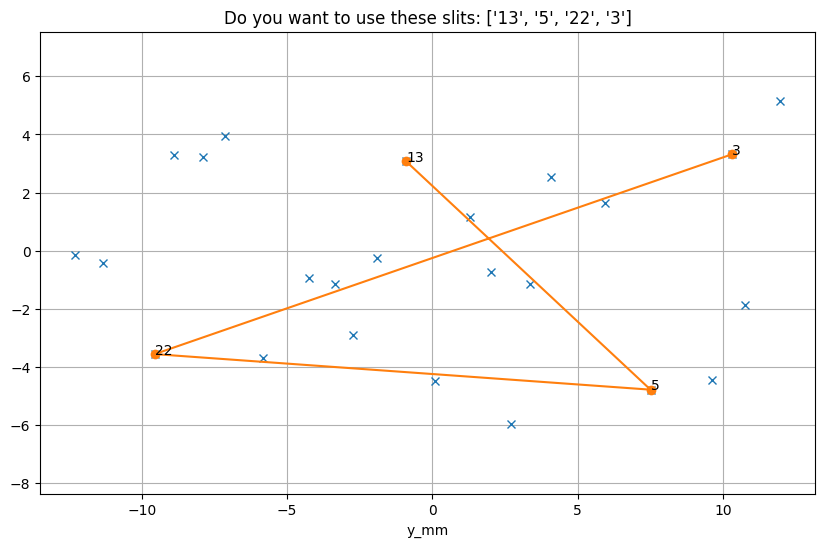

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance
str2,float64,float64,float64,float64,float64,float64,float64
13,-0.9010535220373401,3.0724750743209586,352.3210754394531,0.2851630747318268,-716.6293077353544,669.3198323249817,980.5848268501786
5,7.5025532792065714,-4.778575854140258,352.5201416015625,0.09924089908599854,1454.8073880240172,-104.19883131980896,1458.5341726190982
22,-9.551649625200541,-3.555461620393433,352.11602783203125,0.12818501889705658,-1693.1555673109538,-586.0691319705963,1791.7178356440072
3,10.291182727375155,3.313054276578359,352.58635,0.290982,0.0,0.0,0.0


In [7]:
# slits = ['46', '35', '12', '38"] #F1
# slits =['3', '22','11', '20', '16', '18', '10', '5',"0"] #F2
slits = ['4', '13', '22', '12', '6', '23', "5", "18", "3"] # F3 with 206 #20 can not be reached
slits = ['13', "5",'22', "3"] # small F3 with 206 #20 can not be reached
# slits = ['OVI14', '36', '4', 'QSO1', 'LyC7', '11',"7"] #F4
# slits = ['17', '6', '14', '1', '16', '7',"10","0","16"] #QSO
F1['Internal-count'] = F1['Internal-count'].astype(str)
F1p = F1.to_pandas()
from functools import reduce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# selected_slits = F1[mask.values]['Internal-count',"x_mm","y_mm","ra","dec"]
selected_slits = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1p[F1p['Internal-count'] == i],slits))))
ra,dec = "RA", "DEC"
x,y = "x_mm","y_mm"
plt.figure(figsize=(10,6))
plt.plot(F1[x],F1[y],"x")
plt.plot(selected_slits[x],selected_slits[y],"-o")
for s in selected_slits:
    plt.text(s[x],s[y],s["Internal-count"])
plt.xlabel("x_mm")
plt.xlabel("y_mm")
plt.title("Do you want to use these slits: %s"%(slits))
plt.axis('equal')
plt.grid()
plt.show()

selected_slits = selected_slits['Internal-count',x,y,ra,dec]
slit_path = selected_slits# vstack((selected_slits,selected_slits[::-1]) )
slit_path["ra_diff"] = list((slit_path[ra][:-1] - slit_path[ra][1:])*np.cos(slit_path[dec][:-1]*np.pi/180)) + [0]
slit_path["dec_diff"] = list((slit_path[dec][:-1] - slit_path[dec][1:])) + [0]

slit_path["ra_diff"] *= 3600
slit_path["dec_diff"] *= 3600
slit_path["angular_distance"] = np.sqrt(slit_path["ra_diff"]** 2 + slit_path["dec_diff"]** 2)
try:
    slit_path.to_pandas().to_clipboard()
except Exception:
    pass
slit_path

The slits table has been copied. Add it to the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [8]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation)
moves = pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"])#,dtype=[("EL",float),("CE",float),("UV_image",float)])
# assert moves.sum(axis=0)[0] <0.1
# assert moves.sum(axis=0)[1] <0.1
moves["UV_image"] = moves["UV_image"].astype(bool)
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

# slit_path['lon'] = [s.lon.deg*3600 for s in slits_coord]
# slit_path['lat'] =  [s.lat.deg*3600 for s in slits_coord]
# slit_path
print("(They have been copied to clipboard, paste it in the spreadsheet)")
try:
    moves.to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves
if ~Hysteresis_compensation:
    print("Carefull, with Hysteresis_compensation==%s the last move to return to the guider is not given. You just need to do -∑all moves"%(Hysteresis_compensation))
    print("You should then add EL=%0.4f and CE=%0.4f"%(moves.sum(axis=0)[0],moves.sum(axis=0)[1]))


slit position in mm on mask: [-0.90105352  3.07247507]
slit position in mm on mask: [ 7.50255328 -4.77857585]
slit position in mm on mask: [-9.55164963 -3.55546162]
slit position in mm on mask: [10.29118273  3.31305428]

targets local coords in siderostat local frame:
EL: 451.8 arcsec ; CE: 32.0 arcsec
EL: 118.7 arcsec ; CE: 379.7 arcsec
EL: 170.6 arcsec ; CE: -326.0 arcsec
EL: 462.0 arcsec ; CE: 495.1 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)
Carefull, with Hysteresis_compensation==False the last move to return to the guider is not given. You just need to do -∑all moves
You should then add EL=462.0197 and CE=495.1387


In [9]:
np.isfinite(slits_coord_obs_det[:,0])

NameError: name 'slits_coord_obs_det' is not defined

The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


Copy below the observed slits position from the [slit tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [10]:
slits_coord_obs_det = np.array([
[ 688.1,	989.7  ],
[ 161.1,	350.6 ],
[ 254.5,	1657.3 ],
[ 707.4,	129.7 ]])



valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs

# if input("Are you sure you computed the barycenter on the line %s? Remember that it's better to use 206 line to probe a bigger part of the detector. It might require gain and longer exposure though. Be sure to always compute the centroid on the same line. (y/n)"%(obs_wave))!="y":
#     raise ValueError("Please change obs_wave parameter (c)")


wave:  0.20619


[<SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.24644108, -0.04930765)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.06166292, -0.24287602)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.09450146, 0.1546502)]>,
 <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (250.42402654, 36.43499699)>): (lon, lat) in deg
     [(0.24938026, -0.30866683)]>]

## 11- Note open-mask guider ref point
## 12- Update model with observed slit positions

Fitting rotation and translation
theta: 35.84052748481783 arcmin
dx: 13.921913029386715 arcsec
dy: 96.32386269601923 arcsec
variances: [2.34681687 0.54004853 0.64800921]

residuals in arcsec: [[ -5.2513627   -5.85662846]
 [  5.79625974   6.17958141]
 [  4.6791861  -14.38903827]
 [ -5.22408314  14.06608532]]
max residual in EL,CE 5.8, 14.4 arcsec
mean residual in EL,CE 5.3, 10.9 arcsec


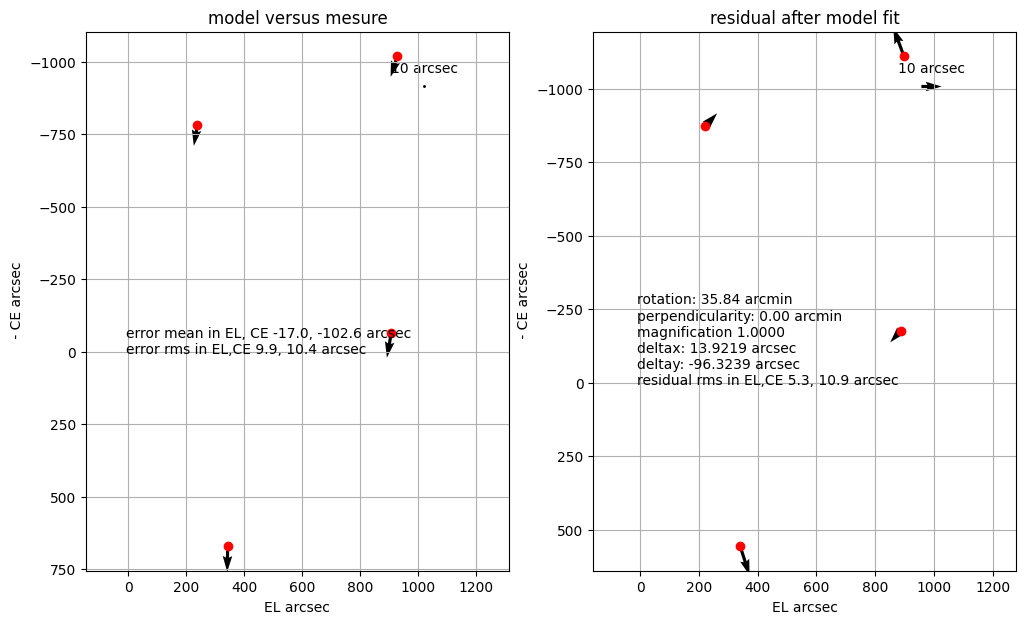

After updating:
    mask_rotation: 35.84052748481783 arcmin
    FOV center in guider: 1361.785823110671 x 498.4606551712294 pix = 660.7303206366934 arcsec x -39.57438448531245 arcsec arcsec
    mask_magnification correction: 1.0  
    


In [11]:
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UV, residuals = G2UV.update_model(slits_coord_valid, slits_coord_obs, plot=True, figsize=(12,7),inplace=True)#,gamma=False)#, labels=slits_valid


### check updating without fitting magnification


Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-90.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (352.3424, 0.21245)>)>
    gamma: 1.0

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.42402654, 36.43499699)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.424026537  36.4349969891  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024648264068189  0.00024664057706659  
NAXIS : 0  0

    mask_rotation: 35.84052748481783 arcmin
    FOV center in guider: 1361.785823110671x498.4606551712294 pix

Fitting rotation, translation and magnification
gamma: 1.0163402346618724
theta: 35.8405274848178 arcmin
dx: 4.055256089666628 arcsec
dy: 101.20895841082137 arcsec
variances: [6.82661356e-04 2.34681687e+00 6.7938822

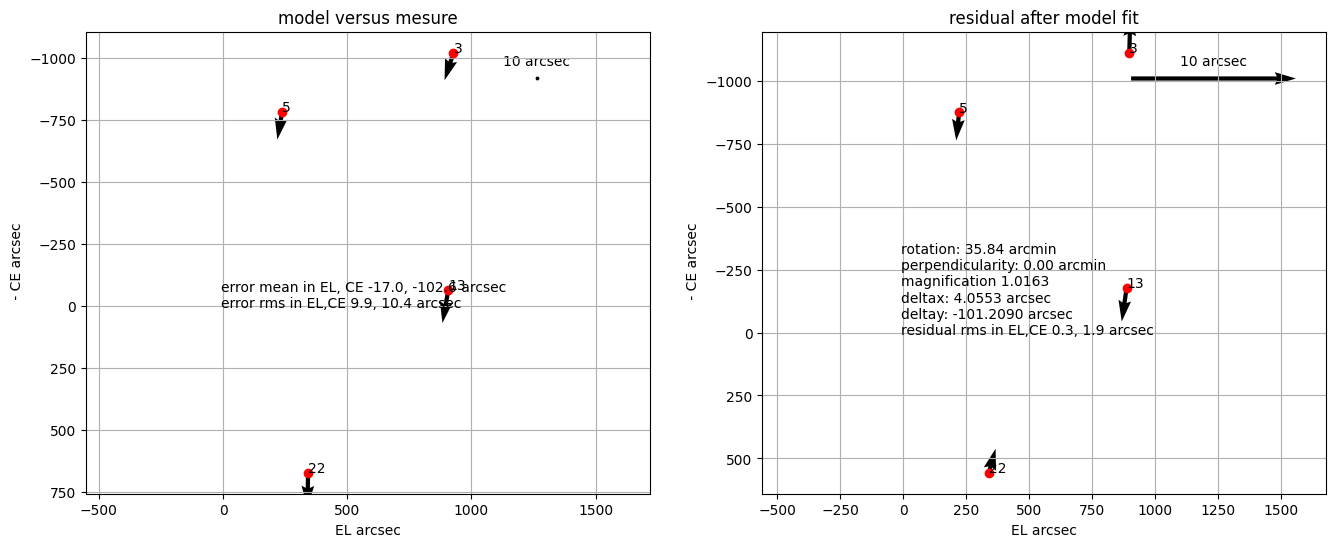

After updating:
    mask_rotation: 71.68105496963562 arcmin
    FOV center in guider: 1378.8401697026045 x 614.3501499684161 pix = 675.9946513957776 arcsec x 67.87642053051448 arcsec arcsec
    mask_magnification correction: 1.0163402346618724  
    


In [12]:
G2UVtest=G2UV.copy()
G2UVtest.FieldP.radial_mag_polynomial = (42.26134, 0., 0.)
G2UVtest.FieldP.radial_mag_inv_polynomial = (1./42.26134, 0., 0.)
G2UVtest.FieldP.gamma = 1.
print(G2UVtest)
G2UVcor_test, residuals = G2UVtest.update_model(slits_coord_valid, slits_coord_obs, labels=slits, plot=True, figsize=(16,6), gamma=True)



slit position in mm on mask: [-0.90105352  3.07247507]
slit position in mm on mask: [ 7.50255328 -4.77857585]
slit position in mm on mask: [-9.55164963 -3.55546162]
slit position in mm on mask: [10.29118273  3.31305428]

targets local coords in siderostat local frame:
EL: 462.3 arcsec ; CE: -19.6 arcsec
EL: 130.6 arcsec ; CE: 335.4 arcsec
EL: 175.2 arcsec ; CE: -378.6 arcsec
EL: 477.5 arcsec ; CE: 448.6 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


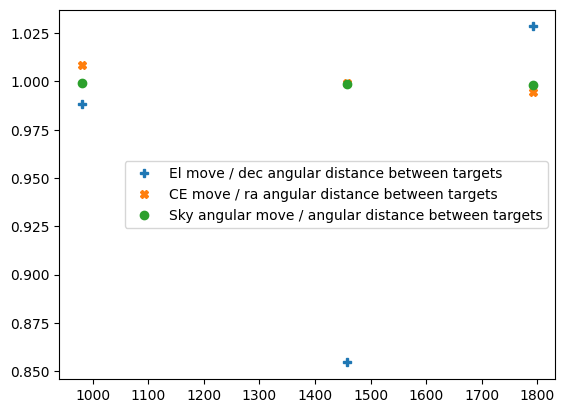

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13,-0.9010535220373401,3.0724750743209586,352.3210754394531,0.2851630747318268,-716.6293077353544,669.3198323249817,980.5848268501786,-331.6895254295376,355.02324025877397,-661.3225758014121,722.8273171668638,979.7075480505703,0.9991053514437641,-0.9880516665765156,-1.0086488361062096
5,7.5025532792065714,-4.778575854140258,352.5201416015625,0.09924089908599854,1454.8073880240172,-104.19883131980896,1458.5341726190982,44.660592395877565,-714.0645891400811,89.04428911890069,-1453.8355034892052,1456.5598362684593,0.9986463557812337,-0.8545613035294449,-0.9993319496843276
22,-9.551649625200541,-3.555461620393433,352.11602783203125,0.12818501889705658,-1693.1555673109538,-586.0691319705963,1791.7178356440072,302.29291748574445,827.2085626451712,602.7116188830773,1684.1966335455686,1788.7927761434207,0.998367455275381,-1.0283967982693822,-0.9947087356068447


In [14]:
moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)


## 16 - Second interation on open mask


wave:  0.20619
Fitting rotation and translation
theta: 1.7654033059078111 arcmin
dx: -5.038828070862196 arcsec
dy: 5.455876070870851 arcsec
variances: [2.4612035  0.61001807 0.68720505]

residuals in arcsec: [[-1.63328153 -7.29084808]
 [-0.96903273 11.70007886]
 [ 2.60231425 -4.40923078]]
max residual in EL,CE 2.6, 11.7 arcsec
mean residual in EL,CE 1.9, 8.4 arcsec


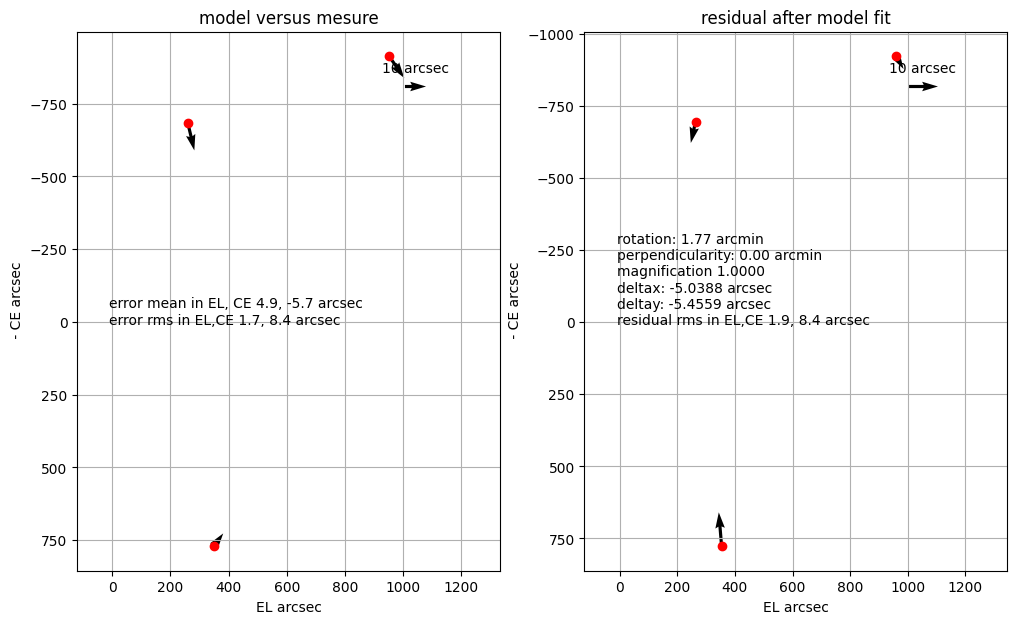

After updating:
    mask_rotation: 37.60593079072564 arcmin
    FOV center in guider: 1356.5010903841721 x 504.683591412252 pix = 655.7118153975747 arcsec x -33.779200265779096 arcsec arcsec
    mask_magnification correction: 1.0  
    
slit position in mm on mask: [-0.90105352  3.07247507]
slit position in mm on mask: [ 7.50255328 -4.77857585]
slit position in mm on mask: [-9.55164963 -3.55546162]
slit position in mm on mask: [10.29118273  3.31305428]

targets local coords in siderostat local frame:
EL: 459.7 arcsec ; CE: -22.5 arcsec
EL: 128.2 arcsec ; CE: 332.7 arcsec
EL: 172.5 arcsec ; CE: -381.4 arcsec
EL: 475.2 arcsec ; CE: 445.6 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


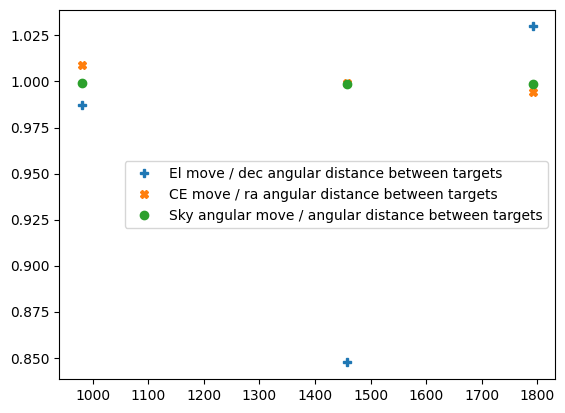

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13,-0.9010535220373401,3.0724750743209586,352.3210754394531,0.2851630747318268,-716.6293077353544,669.3198323249817,980.5848268501786,-331.50514559436664,355.19192636404193,-660.9549592860482,723.1707620771894,979.7129218950439,0.999110831688131,-0.9875024276363111,-1.0091280865452
5,7.5025532792065714,-4.778575854140258,352.5201416015625,0.09924089908599854,1454.8073880240172,-104.19883131980896,1458.5341726190982,44.28641364205726,-714.0908687271414,88.29825151953376,-1453.8890087284599,1456.5678257200489,0.9986518335079402,-0.8474015533679754,-0.9993687279133187
22,-9.551649625200541,-3.555461620393433,352.11602783203125,0.12818501889705658,-1693.1555673109538,-586.0691319705963,1791.7178356440072,302.7282803299401,827.0609870904859,603.5796453218346,1683.8961697162295,1788.8025879430688,0.9983729314722759,-1.0298778973264826,-0.9945312777080313


In [16]:
slits_coord_obs_det = np.array([
[ 709	,1085.7   ],
[ 175.2	,423.5 ],
[ 261.7	,1767.1  ],
[ 735.5	,205.4  ]])

valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
_, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7),inplace=True)#,gamma=False)#, labels=slits_valid


moves, flags, slit_coords = G2UV.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],"P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],"X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],new_cat["frame_divided_sky"],"o",label="Sky angular move / angular distance between targets")
plt.legend()
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


## 13 - Rotate carousel to science mask
## 14 - Note open-mask guider ref point
## 15 - Check corrected model through science mask

wave:  0.20619
Fitting rotation and translation
theta: 1.2793206416687095 arcmin
dx: -0.9034725924145777 arcsec
dy: 0.8599019767362578 arcsec
variances: [2.46117982 0.6084693  0.6849976 ]

residuals in arcsec: [[ 1.22178537 -2.92609218]
 [ 0.81526892  0.61468909]
 [-2.03705429  2.31140309]]
max residual in EL,CE 2.0, 2.9 arcsec
mean residual in EL,CE 1.4, 2.2 arcsec


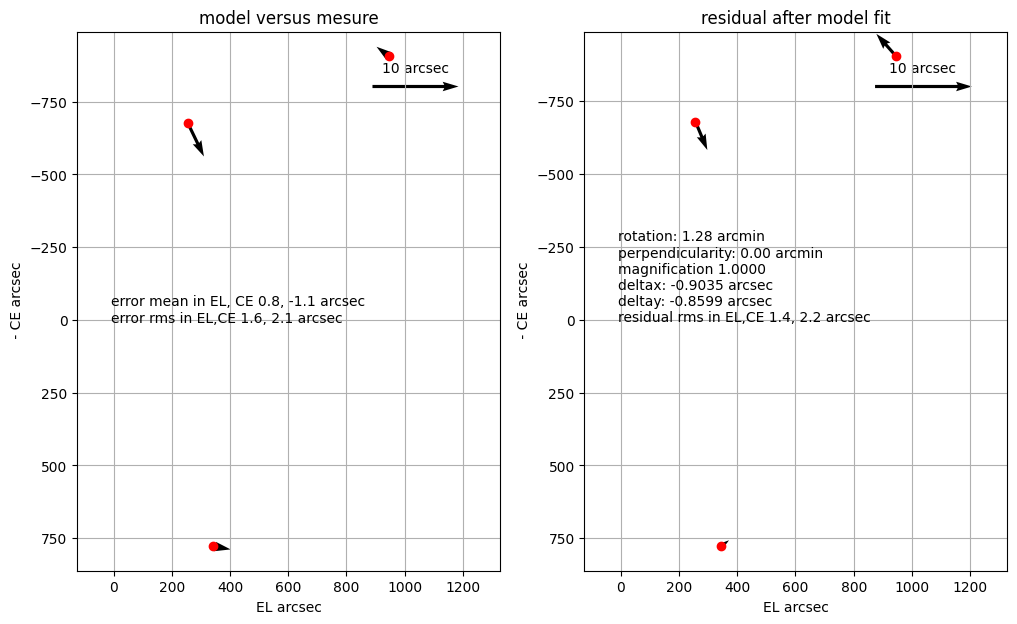

After updating:
    mask_rotation: 40.16457207406293 arcmin
    FOV center in guider: 1354.6248626488464 x 507.0557929347402 pix = 653.9296041154746 arcsec x -31.57170012510549 arcsec arcsec
    mask_magnification correction: 1.0  
    
slit position in mm on mask: [-0.90105352  3.07247507]
slit position in mm on mask: [ 7.50255328 -4.77857585]
slit position in mm on mask: [-9.55164963 -3.55546162]
slit position in mm on mask: [10.29118273  3.31305428]

targets local coords in siderostat local frame:
EL: 458.8 arcsec ; CE: -23.7 arcsec
EL: 127.6 arcsec ; CE: 331.7 arcsec
EL: 171.3 arcsec ; CE: -382.4 arcsec
EL: 474.7 arcsec ; CE: 444.5 arcsec

siderostat moves sequence: 
(They have been copied to clipboard, paste it in the spreadsheet)


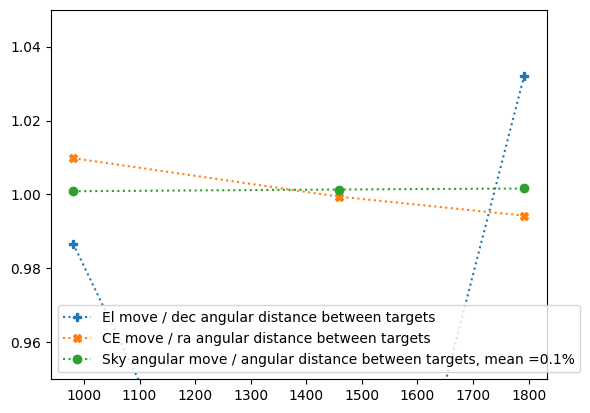

Internal-count,x_mm,y_mm,RA,DEC,ra_diff,dec_diff,angular_distance,EL,CE,El_sky,Cel_sky,Frame_angular_distance,frame_divided_sky,EL_dec_ratio,CE_ra_ratio
str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
13,-0.9010535220373401,3.0724750743209586,352.3210754394531,0.2851630747318268,-716.6293077353544,669.3198323249817,980.5848268501786,-331.2379194843304,355.43640717554797,-660.422163867858,723.6685250094157,979.7211688114161,0.9991192418900293,-0.9867064024889023,-1.0098226756819453
5,7.5025532792065714,-4.778575854140258,352.5201416015625,0.09924089908599854,1454.8073880240172,-104.19883131980896,1458.5341726190982,43.744107414540544,-714.128956361925,87.21700136311094,-1453.9665551528794,1456.580086651573,0.9986602398461353,-0.8370247560207553,-0.9994220314812398
22,-9.551649625200541,-3.555461620393433,352.11602783203125,0.12818501889705658,-1693.1555673109538,-586.0691319705963,1791.7178356440072,303.3592621246736,826.8471023054253,604.8376968241743,1683.460700293846,1788.8176455227117,0.9983813354627611,-1.0320244896544382,-0.9942740837261014


In [18]:
slits_coord_obs_det = np.array([
[ 702.5,	1097 ],
[ 174.2,	431.8],
[ 259.6,	1761.2 ],
[ 728.4,	216  ]])

valid = np.isfinite(slits_coord_obs_det[:,0])
obs_wave =  0.20619
print("wave: ", obs_wave)
slits_coord_valid = [slit_coords[i] for i in np.nonzero(valid)[0]]
# slits_valid = slits[valid]
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
slits_coord_obs
slits_coord_obs = G2UV.detector2guider(slits_coord_obs_det, wave=obs_wave, angle=True  )
weight = np.array( [1.]*16  + [1./(1. + 1e-1)]*16)
G2UVcor, residuals = G2UV.update_model(slits_coord_valid[1:], slits_coord_obs[1:], plot=True, figsize=(12,7),inplace=True)#,gamma=False)#, labels=slits_valid


moves, flags, slit_coords = G2UVcor.compute_autocoll_moves_slits(slits, F1, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
moves = Table.from_pandas(pd.DataFrame(np.hstack((moves,flags[:,None])), columns=["EL","CE","UV_image"]))
print("(They have been copied to clipboard, paste it in the spreadsheet)")
moves["EL_abs"] =  [np.sum(moves["EL"][:i+1]) for i in range(len(moves))]
moves["CE_abs"] = [np.sum(moves["CE"][:i+1]) for i in range(len(moves))]

try:
    moves.to_pandas().to_clipboard()
except Exception as e:
    print("Could not copy: ", e)
moves

new_cat = slit_path[:-1]
new_cat["EL"] = moves["EL"][1:]
new_cat["CE"] = moves["CE"][1:]

new_cat["El_sky"] = new_cat["EL"]  * 2 * Elg
new_cat["Cel_sky"] = new_cat["CE"] * 2 * CEg
new_cat["Frame_angular_distance"] = np.sqrt(new_cat["El_sky"]**2 + new_cat["Cel_sky"]**2)
new_cat["frame_divided_sky"] = new_cat["Frame_angular_distance"] / new_cat["angular_distance"]
new_cat["EL_dec_ratio"] =   new_cat["El_sky"] / new_cat["dec_diff"]
new_cat["CE_ra_ratio"] =   new_cat["Cel_sky"] / new_cat["ra_diff"]
# new_cat
# new_cat.to_pandas().to_clipboard()



plt.figure()
plt.plot(new_cat["angular_distance"],-new_cat["EL_dec_ratio"],":P",label="El move / dec angular distance between targets")
plt.plot(new_cat["angular_distance"],-new_cat["CE_ra_ratio"],":X",label="CE move / ra angular distance between targets")
plt.plot(new_cat["angular_distance"],1/new_cat["frame_divided_sky"],":o",label="Sky angular move / angular distance between targets, mean =%0.1f%%"%(100*(1/new_cat["frame_divided_sky"].mean()-1)))
plt.legend()
plt.ylim((0.95,1.05))
plt.show()
new_cat#["ra_diff","dec_diff","El_sky","Cel_sky","frame_divided_sky","EL_dec_ratio","CE_ra_ratio"]#,"EL_moves","CE_moves"


### save corrected model for future use (eg redo the calib on same field)

In [19]:
#G2UVcor.save(filename="Calibration/Mappings/2023/XY/F3_XY_230620.pkl")



## 16 - Note science-mask guider ref point
## 17 - Go through the Star sequence
[36, 40, 46, 21 ]
we did not have the time to do this because G2UV was not well

In [20]:
star_target_path = "Calibration/Targets/2022/GuidingStars/%s_guidingstars.fits"%(Field)
# il faut que le centre soit bien defini à l'arcseconde pres.
F1_stars = Table.read(star_target_path, format='fits').to_pandas()

# stars =[29, 34, 18, 14 ]
stars =[20,5,9 ]
selected_stars = Table.from_pandas((reduce(pd.DataFrame.append, map(lambda i: F1_stars[F1_stars['Internal count'] == i],stars))))
# G2UVcor.FOV_center_guider_coord = 0.18182478, 0.00998363
star_moves, flags, stars_coord = G2UVcor.compute_autocoll_move_stars(stars, F1_stars, hystcomp = Hysteresis_compensation, CEg = CEg, Elg = Elg)
star_moves = pd.DataFrame(np.hstack((star_moves,flags[:,None])), columns=["EL","CE","Image"])
star_moves.to_clipboard()



# stars_path = vstack((selected_stars,selected_stars[::-1]) )
# selected_stars['lon'] = [s.lon.deg*3600 for s in stars_coord]
# selected_stars['lat'] =  [s.lat.deg*3600 for s in stars_coord]
# print("(They have been copied to clipboard, paste it in the spreadsheet)")
# star_moves.to_clipboard()
# star_moves




targets local coords in siderostat local frame:
EL: -254.2 arcsec ; CE: 103.5 arcsec
EL: -130.8 arcsec ; CE: -179.4 arcsec
EL: 138.1 arcsec ; CE: -114.0 arcsec

siderostat moves sequence: 


The moves has been copied. Add it to the [moves tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)

In [21]:
selection = selected_stars['Internal count',
 'RA',
 'DEC',
 'X',
 'Y',
 'GAIA gband',
 'SDSS gband',
 'SDSS rband',
 'Xguider',
 'Yguider']
# selection=vstack((selection,selection[::-1]))
selection.add_row(["-99",-99,-99,640,540,-99,-99,-99,-99,-99])
selection.to_pandas().to_clipboard()
selection

Internal count,RA,DEC,X,Y,GAIA gband,SDSS gband,SDSS rband,Xguider,Yguider
int64,float64,float64,float64,float64,int64,object,object,float64,float64
20,352.387774,-0.111235,1.930845,-13.773961,--,12,12,58.50638377206623,322.426324860575
5,352.228576,-0.041124,-4.843635,-10.790471,9,10,9,353.4101855036889,982.9681967990201
9,352.267202,0.107397,-3.199912,-4.470323,--,13,12,955.7861839419787,813.2265808353644
-99,-99.0,-99.0,640.0,540.0,-99,-99,-99,-99.0,-99.0


The stars table has been copied. Add it to the [stars tab of this spreadsheet](https://docs.google.com/spreadsheets/d/19jO0fZ0FL0zZKt8IgJ_DMlZrbCD0VXpYVeulKzXtHzY/edit#gid=0)
## 18 - Through focus guide star 1
## 19 - Track mask to guider changes
------------------------------------------------------